In [1]:
# pip install pmdarima

In [2]:
# pip install prophet

In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# from pmdarima import auto_arima
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
pd.set_option("display.max_columns",None)

In [5]:
URL_DATA = 'https://storage.data.gov.my/transportation/ridership_headline.parquet'

df = pd.read_parquet(URL_DATA)
if 'date' in df.columns: df['date'] = pd.to_datetime(df['date'])
df

,date,bus_rkl,bus_rkn,bus_rpn,rail_lrt_ampang,rail_mrt_kajang,rail_lrt_kj,rail_monorail,rail_mrt_pjy,rail_ets,rail_intercity,rail_komuter_utara,rail_tebrau,rail_komuter
0,2019-01-01,<NA>,<NA>,<NA>,113357,114173,139634,35804,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2019-01-02,<NA>,<NA>,<NA>,182715,169316,274224,31859,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2019-01-03,<NA>,<NA>,<NA>,187904,175304,286469,31893,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,2019-01-04,<NA>,<NA>,<NA>,198420,187891,304755,34121,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,2019-01-05,<NA>,<NA>,<NA>,120773,112660,145036,29950,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2025-12-27,147215,0,44915,177134,210405,162920,59621,106807,15301,5992,18748,9399,19525
2553,2025-12-28,140635,0,47185,134928,183634,145583,54335,93087,15683,5874,23595,8585,22723
2554,2025-12-29,204567,0,48795,192173,259778,245179,60628,156216,14192,5033,19241,9060,28596
2555,2025-12-30,206759,0,48450,198262,269198,256322,64960,161608,13947,5172,17174,9941,27854


### Our focus is on LRT and MRT lines only, so we'll focus on Ampang LRT Line, Kelana Jaya LRT Line, Kajang MRT Line and Putrajaya MRT Line

In [6]:
# Select only the columns which are relevant to our project for now. 
df_selected = df[['date','rail_lrt_ampang','rail_lrt_kj','rail_mrt_kajang','rail_mrt_pjy']] 
df_selected = df_selected.rename(columns={'rail_lrt_ampang':'LRT_Ampang_Line','rail_lrt_kj':'LRT_Kelana_Jaya_Line','rail_mrt_kajang':'MRT_Kajang_Line',
                                          'rail_mrt_pjy':'MRT_Putrajaya_Line'}) 
df_selected

,date,LRT_Ampang_Line,LRT_Kelana_Jaya_Line,MRT_Kajang_Line,MRT_Putrajaya_Line
0,2019-01-01,113357,139634,114173,<NA>
1,2019-01-02,182715,274224,169316,<NA>
2,2019-01-03,187904,286469,175304,<NA>
3,2019-01-04,198420,304755,187891,<NA>
4,2019-01-05,120773,145036,112660,<NA>
...,...,...,...,...,...
2552,2025-12-27,177134,162920,210405,106807
2553,2025-12-28,134928,145583,183634,93087
2554,2025-12-29,192173,245179,259778,156216
2555,2025-12-30,198262,256322,269198,161608


## Exploratory Data Analysis

In [7]:
# In this EDA (exploratory data analysis, we'll check for null values, duplicates and the data types 
# This is a well-maintained dataset, so null values and duplicates should not present but it's a good practice to do this at the beginning of each 
# analysis to make sure we don't face any issues with presence of null values and duplicates later on. 

# We're definitely going to have null values in the MRT Putrajaya line because the MRT Putrajaya line was only started and opened on June 16, 2022 
# and the data we have starts all the way back from 2019. It was started in two phases : Phase One (Kwasa Damansara to Kampung Batu) was opened on 
# June 16, 2022 and Phase Two (Kampung Baru to Putrajaya Sentral) was opened on March 16, 2023. 

df_selected.isnull().sum()

date                       0
LRT_Ampang_Line            0
LRT_Kelana_Jaya_Line       0
MRT_Kajang_Line            0
MRT_Putrajaya_Line      1262
dtype: int64

In [8]:
df_selected[df_selected['MRT_Putrajaya_Line'].notnull()]

,date,LRT_Ampang_Line,LRT_Kelana_Jaya_Line,MRT_Kajang_Line,MRT_Putrajaya_Line
1262,2022-06-16,143577,195241,158121,13367
1263,2022-06-17,157576,207611,171000,22621
1264,2022-06-18,123615,143497,149262,28885
1265,2022-06-19,114630,127028,141530,32066
1266,2022-06-20,152913,198575,164577,21564
...,...,...,...,...,...
2552,2025-12-27,177134,162920,210405,106807
2553,2025-12-28,134928,145583,183634,93087
2554,2025-12-29,192173,245179,259778,156216
2555,2025-12-30,198262,256322,269198,161608


In [9]:
df_selected.duplicated().sum()

np.int64(0)

In [10]:
df_selected[df_selected['date'].duplicated(keep=False)]

,date,LRT_Ampang_Line,LRT_Kelana_Jaya_Line,MRT_Kajang_Line,MRT_Putrajaya_Line


In [11]:
df_selected.dtypes

date                    datetime64[ns]
LRT_Ampang_Line                  Int64
LRT_Kelana_Jaya_Line             Int64
MRT_Kajang_Line                  Int64
MRT_Putrajaya_Line               Int64
dtype: object

## Analysis of yearly volume for each of the line

In [12]:
# The analysis of the yearly volume would be quite incomplete since we don't have the data for December 2025 and the MRT line for Putrajaya 
# don't have data from January 2019 to May 2022. Plus, only a specific section of the MRT line has been completed at that point so the numbers are 
# going to be much higher from March 2023. 

# Create new columns for year-month, year only and month only. Before that, we have to change date column to string type. 
df_selected['date'] = df_selected['date'].astype(str) 
df_selected['year_month'] = df_selected['date'].str[:7] 
df_selected['year'] = df_selected['date'].str[:4] 
df_selected['month'] = df_selected['date'].str[5:7] 
df_selected

,date,LRT_Ampang_Line,LRT_Kelana_Jaya_Line,MRT_Kajang_Line,MRT_Putrajaya_Line,year_month,year,month
0,2019-01-01,113357,139634,114173,<NA>,2019-01,2019,01
1,2019-01-02,182715,274224,169316,<NA>,2019-01,2019,01
2,2019-01-03,187904,286469,175304,<NA>,2019-01,2019,01
3,2019-01-04,198420,304755,187891,<NA>,2019-01,2019,01
4,2019-01-05,120773,145036,112660,<NA>,2019-01,2019,01
...,...,...,...,...,...,...,...,...
2552,2025-12-27,177134,162920,210405,106807,2025-12,2025,12
2553,2025-12-28,134928,145583,183634,93087,2025-12,2025,12
2554,2025-12-29,192173,245179,259778,156216,2025-12,2025,12
2555,2025-12-30,198262,256322,269198,161608,2025-12,2025,12


In [13]:
# Group it based on the line for yearly volume based on each year_month 

df_yearly = df_selected.groupby('year')[['LRT_Ampang_Line','LRT_Kelana_Jaya_Line','MRT_Kajang_Line','MRT_Putrajaya_Line']].sum().reset_index()
df_yearly

,year,LRT_Ampang_Line,LRT_Kelana_Jaya_Line,MRT_Kajang_Line,MRT_Putrajaya_Line
0,2019,65147222,94657974,63952805,0
1,2020,34715565,45307182,33168335,0
2,2021,21938973,25123614,19573010,0
3,2022,44151332,55015765,45348209,4147577
4,2023,50590579,73763592,66501508,29555851
5,2024,64022915,84733297,84520994,48126110
6,2025,71019400,89632502,92737532,55670064


In [14]:
# Create a dataframe where there are columns of year, LRT/MRT Line and it's respective number of ridership so that it can be read in a line graph

df_yearly_melted = df_yearly.melt(
    id_vars = 'year',
    var_name = 'LRT/MRT Line',
    value_name = 'Number of ridership'
) 

df_yearly_melted

,year,LRT/MRT Line,Number of ridership
0,2019,LRT_Ampang_Line,65147222
1,2020,LRT_Ampang_Line,34715565
2,2021,LRT_Ampang_Line,21938973
3,2022,LRT_Ampang_Line,44151332
4,2023,LRT_Ampang_Line,50590579
5,2024,LRT_Ampang_Line,64022915
6,2025,LRT_Ampang_Line,71019400
7,2019,LRT_Kelana_Jaya_Line,94657974
8,2020,LRT_Kelana_Jaya_Line,45307182
9,2021,LRT_Kelana_Jaya_Line,25123614


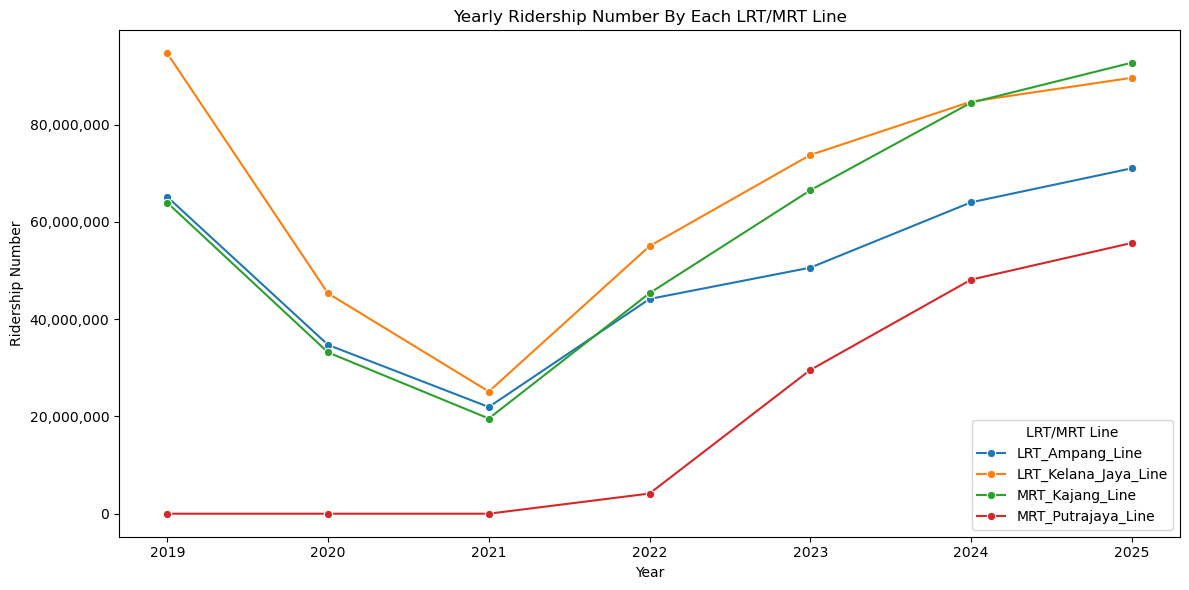

In [15]:
# Let's create a line graph and see the yearly volume from 2019 to 2025 for each of the line 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_yearly_melted, 
    x='year', 
    y='Number of ridership',
    hue='LRT/MRT Line',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Yearly Ridership Number By Each LRT/MRT Line') 
plt.xlabel('Year') 
plt.ylabel('Ridership Number') 
plt.legend(title='LRT/MRT Line')
plt.tight_layout() 
plt.show()

### Kelana Jaya line records the highest number of ridership in 2019 followed by LRT Ampang Line, MRT Kajang Line. We cannot take MRT Putrajaya Line into comparison here because MRT Putrajaya line did not get launched until the year of 2022. 
### We can divide this analysis into pre-MCO and post-MCO due to COVID. The numbers dropped drastically for all the three lines in the year of 2020 and 2021 because of Movement Control Order that was implemented in the year of 2020 and 2021 which made the majority of workforce to work from home (WFH). 
### The numbers started to climb up beginning from the year of 2022 once MCO has been lifted. MRT Kajang Line ridership numbers has surpassed the pre-COVID numbers. In 2019, the ridership number for that year was 63,952,805 but in the year of 2025 (up to November 2025), the ridership number has increased to 84,369,266. As for LRT Ampang Line, the numbers for 2025 has come close to the pre-MCO times and with the addition of December 2025's numbers later on, it will surpass the ridership numbers in 2019. The only line where it has not come close to the pre-COVID numbers is LRT Kelana Jaya line. The 2019 ridership number for this line was 94,657,974 but for the year of 2025 (up to November 2025), the ridership number was 81,848,389. We will have to wait for the data of December 2025 to come in to see how does it look when the total volume for the year is compared. 

## Analysis of monthly volume for each line for the year of 2019

In [16]:
# We'll focus on each year and see if there's any significant spike or decline in any of the months. 
# Let's create the corresponding months according to the values in the month column. For example, 2019-01 = January 2019

df_selected['year_month'] = pd.to_datetime(df_selected['year_month'], format='%Y-%m')
df_selected['year_month_str'] = df_selected['year_month'].dt.strftime('%B %Y')
df_selected['year_month'] = df_selected['year_month'].astype(str) 
df_selected['year_month'] = df_selected['year_month'].str[:7] 
df_selected

,date,LRT_Ampang_Line,LRT_Kelana_Jaya_Line,MRT_Kajang_Line,MRT_Putrajaya_Line,year_month,year,month,year_month_str
0,2019-01-01,113357,139634,114173,<NA>,2019-01,2019,01,January 2019
1,2019-01-02,182715,274224,169316,<NA>,2019-01,2019,01,January 2019
2,2019-01-03,187904,286469,175304,<NA>,2019-01,2019,01,January 2019
3,2019-01-04,198420,304755,187891,<NA>,2019-01,2019,01,January 2019
4,2019-01-05,120773,145036,112660,<NA>,2019-01,2019,01,January 2019
...,...,...,...,...,...,...,...,...,...
2552,2025-12-27,177134,162920,210405,106807,2025-12,2025,12,December 2025
2553,2025-12-28,134928,145583,183634,93087,2025-12,2025,12,December 2025
2554,2025-12-29,192173,245179,259778,156216,2025-12,2025,12,December 2025
2555,2025-12-30,198262,256322,269198,161608,2025-12,2025,12,December 2025


In [17]:
# Let's only take the relevant data to get the monthly volume data analysis 
df_selected_monthly = df_selected.groupby(['year_month','year_month_str'])[['LRT_Ampang_Line','LRT_Kelana_Jaya_Line','MRT_Kajang_Line','MRT_Putrajaya_Line']].sum().reset_index() 
df_selected_monthly

,year_month,year_month_str,LRT_Ampang_Line,LRT_Kelana_Jaya_Line,MRT_Kajang_Line,MRT_Putrajaya_Line
0,2019-01,January 2019,5363000,7900483,5206125,0
1,2019-02,February 2019,4454115,6523515,4319140,0
2,2019-03,March 2019,5617697,8127743,5393067,0
3,2019-04,April 2019,5571821,8189219,5294479,0
4,2019-05,May 2019,5458497,7746135,5155333,0
...,...,...,...,...,...,...
79,2025-08,August 2025,6343844,8095935,8301044,5052583
80,2025-09,September 2025,5664639,7143358,7530148,4543928
81,2025-10,October 2025,6205243,7739381,8015428,4753510
82,2025-11,November 2025,5909107,7417502,7803280,4759332


In [18]:
# Melt the data so that it contains the columns of year_month, LRT/MRT line types and the number of ridership 

df_monthly_melted = df_selected_monthly.melt(
    id_vars = ['year_month','year_month_str'],
    var_name = 'LRT/MRT Line',
    value_name = 'Number of ridership'
) 

df_monthly_melted

,year_month,year_month_str,LRT/MRT Line,Number of ridership
0,2019-01,January 2019,LRT_Ampang_Line,5363000
1,2019-02,February 2019,LRT_Ampang_Line,4454115
2,2019-03,March 2019,LRT_Ampang_Line,5617697
3,2019-04,April 2019,LRT_Ampang_Line,5571821
4,2019-05,May 2019,LRT_Ampang_Line,5458497
...,...,...,...,...
331,2025-08,August 2025,MRT_Putrajaya_Line,5052583
332,2025-09,September 2025,MRT_Putrajaya_Line,4543928
333,2025-10,October 2025,MRT_Putrajaya_Line,4753510
334,2025-11,November 2025,MRT_Putrajaya_Line,4759332


In [19]:
# Filter the year to the the year of 2019 to build the line graph for the year of 2019
# We can take out the MRT Putrajaya line for this graph since MRT Putrajaya line is launched in the year of 2022

df_monthly_melted['year'] = df_monthly_melted['year_month'].str[:4] 
df_2019 = df_monthly_melted[(df_monthly_melted['year'] == '2019') & (df_monthly_melted['LRT/MRT Line'] != 'MRT_Putrajaya_Line')].reset_index(drop=True) 
df_2019 = df_2019.drop(columns=['year_month_str','year'],axis=1) 
df_2019

,year_month,LRT/MRT Line,Number of ridership
0,2019-01,LRT_Ampang_Line,5363000
1,2019-02,LRT_Ampang_Line,4454115
2,2019-03,LRT_Ampang_Line,5617697
3,2019-04,LRT_Ampang_Line,5571821
4,2019-05,LRT_Ampang_Line,5458497
5,2019-06,LRT_Ampang_Line,4906864
6,2019-07,LRT_Ampang_Line,5757222
7,2019-08,LRT_Ampang_Line,5577557
8,2019-09,LRT_Ampang_Line,5182224
9,2019-10,LRT_Ampang_Line,5816211


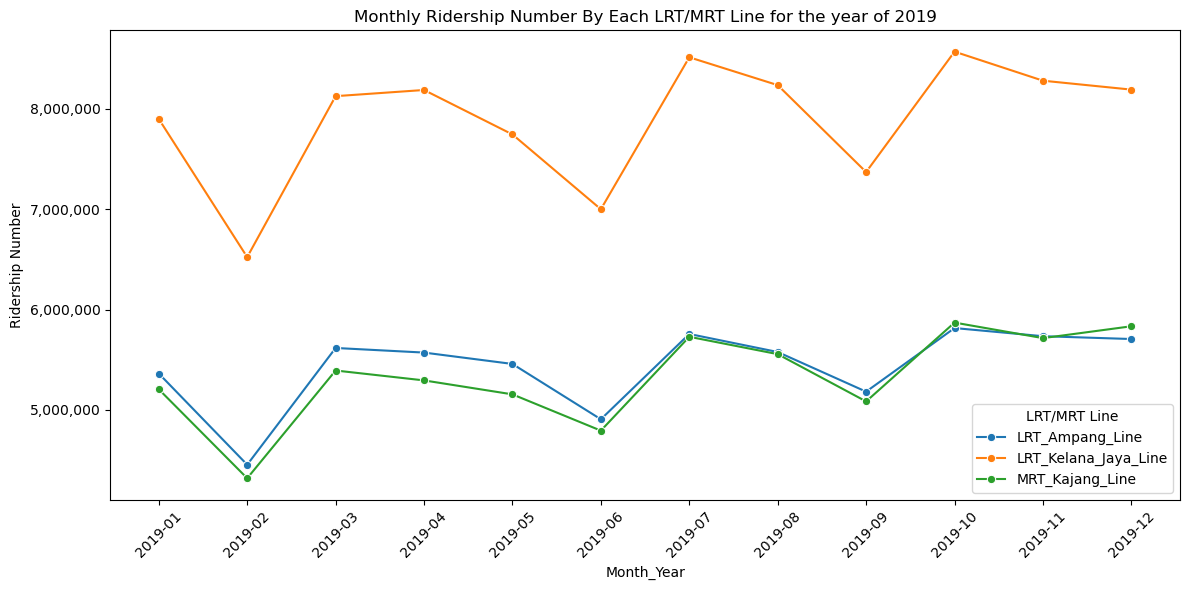

In [20]:
# Let's create a line graph to see the ridership numbers for each month for the year of 2019 for each of the LRT/MRT line 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_2019, 
    x='year_month', 
    y='Number of ridership',
    hue='LRT/MRT Line',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Monthly Ridership Number By Each LRT/MRT Line for the year of 2019') 
plt.xlabel('Month_Year') 
plt.ylabel('Ridership Number') 
plt.legend(title='LRT/MRT Line')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

### The monthly ridership in 2019 exhibits intra-year seasonality characterised by recurring short-term troughs followed by rapid rebounds, producing a V-shaped pattern approximately every 3–4 months for each of the three lines. 

## Analysis of monthly volume for each line for the year of 2020

In [21]:
df_2020 = df_monthly_melted[(df_monthly_melted['year'] == '2020') & (df_monthly_melted['LRT/MRT Line'] != 'MRT_Putrajaya_Line')].reset_index(drop=True)
df_2020 = df_2020.drop(columns=['year_month_str','year'],axis=1) 
df_2020

,year_month,LRT/MRT Line,Number of ridership
0,2020-01,LRT_Ampang_Line,5389518
1,2020-02,LRT_Ampang_Line,5161307
2,2020-03,LRT_Ampang_Line,3144777
3,2020-04,LRT_Ampang_Line,394171
4,2020-05,LRT_Ampang_Line,1205494
5,2020-06,LRT_Ampang_Line,2297520
6,2020-07,LRT_Ampang_Line,3195946
7,2020-08,LRT_Ampang_Line,3227890
8,2020-09,LRT_Ampang_Line,3549250
9,2020-10,LRT_Ampang_Line,2592837


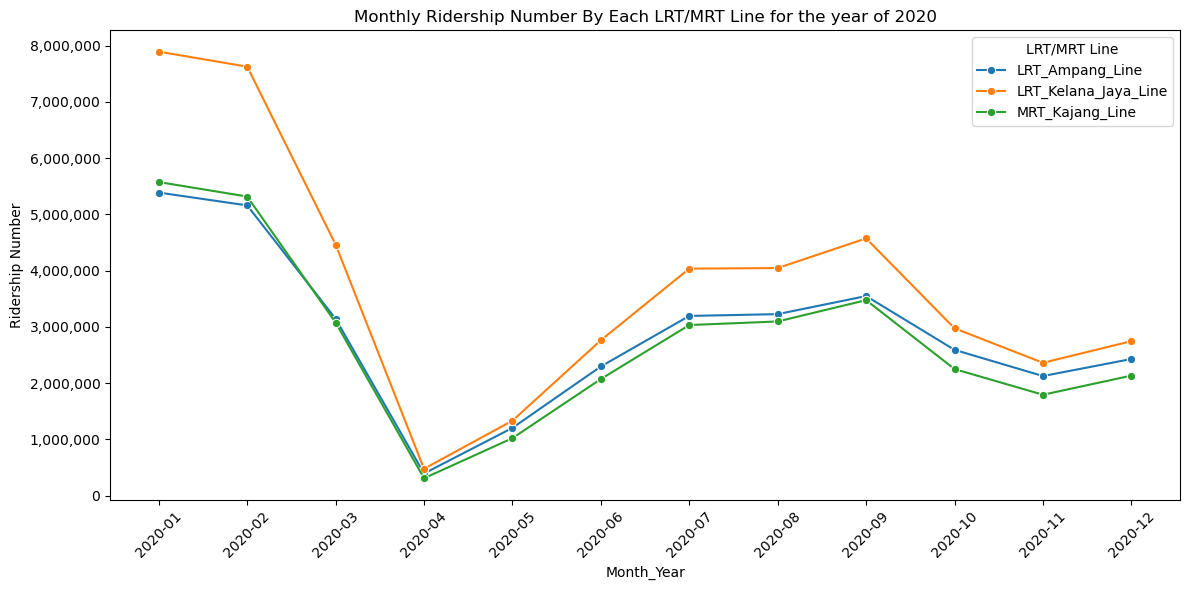

In [22]:
# Let's create a line graph to see the ridership numbers for each month for the year of 2020 for each of the LRT/MRT line 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_2020, 
    x='year_month', 
    y='Number of ridership',
    hue='LRT/MRT Line',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Monthly Ridership Number By Each LRT/MRT Line for the year of 2020') 
plt.xlabel('Month_Year') 
plt.ylabel('Ridership Number') 
plt.legend(title='LRT/MRT Line')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

### Based on the line graph, we can see that the dip started happening in March 2020 and kept on dipping drastically and reached the lowest point in April 2020 which coincides with the implementation of Movement Control Order (MCO) which was started to be implemented on March 2020 due to COVID-19 pandemic. The numbers went up slightly higher in the following months, but demand remained significantly below 2019 levels throughout the remainder of the year which reflects on majority of the workforce going on sustained work-from-home arrangements and ongoing mobility constraints. 

## Analysis of monthly volume for each line for the year of 2021

In [23]:
df_2021 = df_monthly_melted[(df_monthly_melted['year'] == '2021') & (df_monthly_melted['LRT/MRT Line'] != 'MRT_Putrajaya_Line')].reset_index(drop=True)
df_2021 = df_2021.drop(columns=['year_month_str','year'],axis=1) 
df_2021

,year_month,LRT/MRT Line,Number of ridership
0,2021-01,LRT_Ampang_Line,1824666
1,2021-02,LRT_Ampang_Line,1698744
2,2021-03,LRT_Ampang_Line,2601245
3,2021-04,LRT_Ampang_Line,2705960
4,2021-05,LRT_Ampang_Line,1799251
5,2021-06,LRT_Ampang_Line,731375
6,2021-07,LRT_Ampang_Line,824844
7,2021-08,LRT_Ampang_Line,1061950
8,2021-09,LRT_Ampang_Line,1557367
9,2021-10,LRT_Ampang_Line,2034527


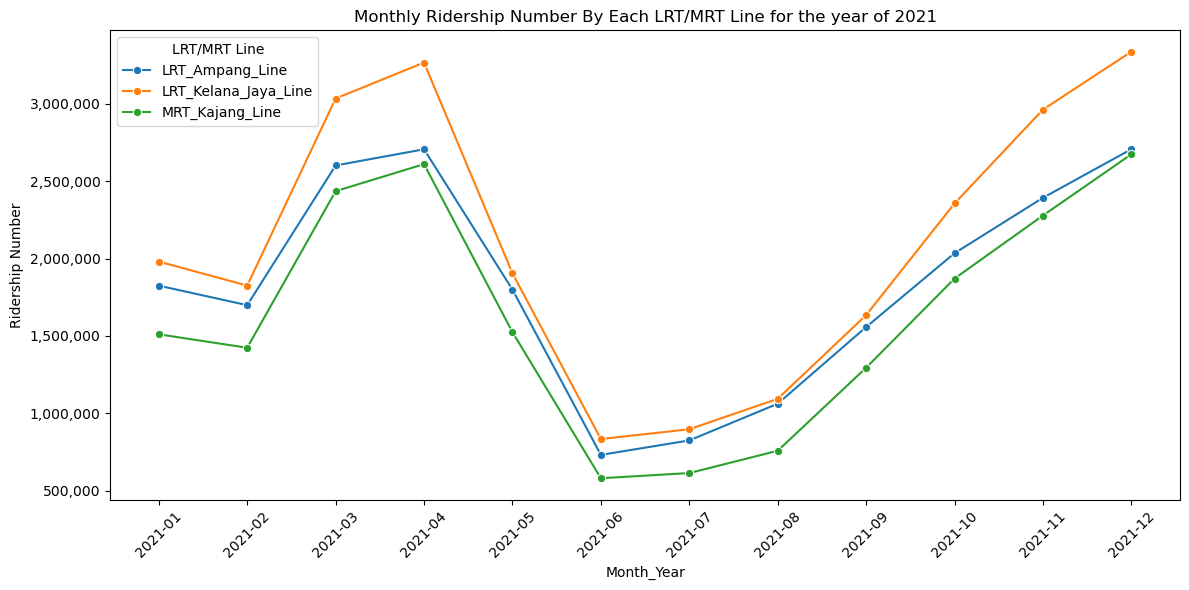

In [24]:
# Let's create a line graph to see the ridership numbers for each month for the year of 2021 for each of the LRT/MRT line 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_2021, 
    x='year_month', 
    y='Number of ridership',
    hue='LRT/MRT Line',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Monthly Ridership Number By Each LRT/MRT Line for the year of 2021') 
plt.xlabel('Month_Year') 
plt.ylabel('Ridership Number') 
plt.legend(title='LRT/MRT Line')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

### For the year of 2021, it seems that the ridership numbers were climbing back at the beginning of the year before dipping in the month of April 2021 and falling further over the subsequent two months. This pattern coincides with the rising cases of COVID-19 pandemic as well as re-introduction of stricter MCO measures that were implemented following the rising cases. Then, it slowly start climbing back from July 2021 to December 2021, approaching levels observed prior to the mid-year decline, although demand remained below pre-pandemic norms.  

## Analysis of monthly volume for each line for the year of 2022

In [25]:
df_2022 = df_monthly_melted[df_monthly_melted['year'] == '2022'].reset_index(drop=True)
df_2022 = df_2022.drop(columns=['year_month_str','year'],axis=1) 
df_2022

,year_month,LRT/MRT Line,Number of ridership
0,2022-01,LRT_Ampang_Line,2828567
1,2022-02,LRT_Ampang_Line,2171266
2,2022-03,LRT_Ampang_Line,2693615
3,2022-04,LRT_Ampang_Line,3228674
4,2022-05,LRT_Ampang_Line,3339042
5,2022-06,LRT_Ampang_Line,4344595
6,2022-07,LRT_Ampang_Line,4266733
7,2022-08,LRT_Ampang_Line,4293066
8,2022-09,LRT_Ampang_Line,4286962
9,2022-10,LRT_Ampang_Line,4259135


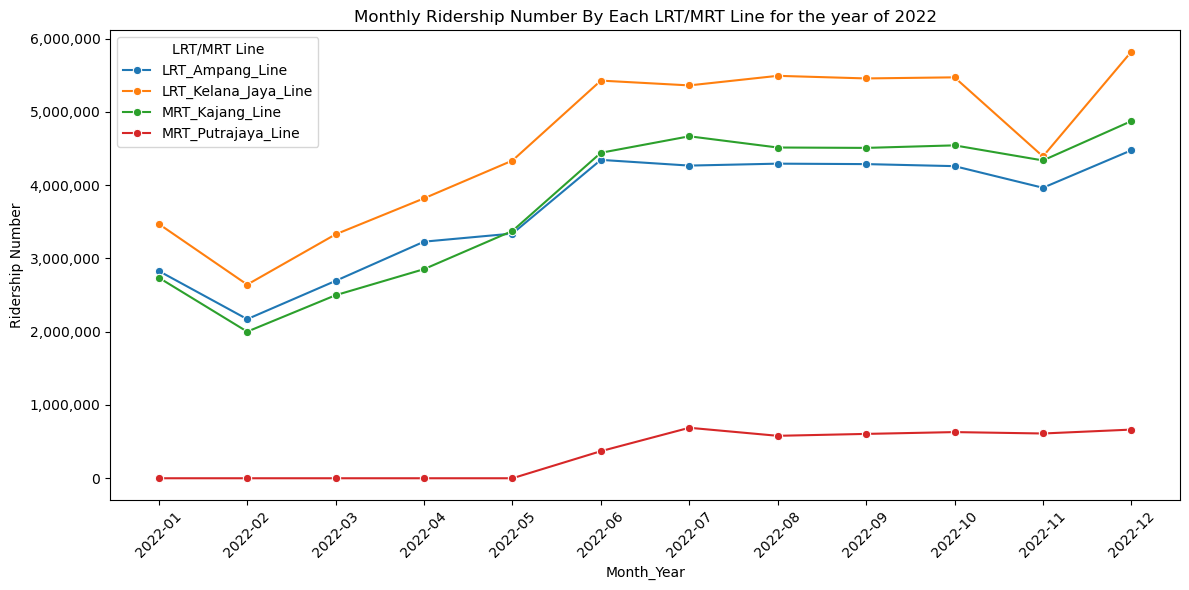

In [26]:
# Let's create a line graph to see the ridership numbers for each month for the year of 2022 for each of the LRT/MRT line 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_2022, 
    x='year_month', 
    y='Number of ridership',
    hue='LRT/MRT Line',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Monthly Ridership Number By Each LRT/MRT Line for the year of 2022') 
plt.xlabel('Month_Year') 
plt.ylabel('Ridership Number') 
plt.legend(title='LRT/MRT Line')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

### For the year of 2022, the ridership numbers for the three mature lines (LRT Kelana Jaya, MRT Kajang and LRT Ampang) follows nearly the same pattern throughout the year where it dipped slightly in February 2022 before gradually increasing throughout the subsequent months till June 2022. The ridership numbers entered a more stable range from June 2022 till December 2022 with relatively smaller month-to-month fluctuations except for LRT Kelana Jaya. Compared to the slight dip experienced by LRT Ampang and MRT Kajang in November 2022, the dip experienced by LRT Kelana Jaya is much deeper in November 2022 but it rose back to it's highest ridership number for the year of 2022 in December 2022. 

### When comparing the numbers to the pre-pandemic levels in 2019 for all the three mature lines, we can observe that MRT Kajang Line recovered more quickly than the other two mature lines, reaching near to the monthly ridership levels earlier in the recovery period. 

### For MRT Putrajaya line, it only started it's operations on June 16, 2022 and this is only the starting of Phase 1. As such, it's ridership number in 2022 reflects an early ramp-up period rather than steady-state demand. From July to December 2022, ridership numbers appear relatively stable, suggesting gradual adoption. Ridership number is expected to increase further in 2023 as awareness grows and Phase 2 of the line becomes operational. 

## Analysis of monthly volume for each line for the year of 2023

In [27]:
df_2023 = df_monthly_melted[df_monthly_melted['year'] == '2023'].reset_index(drop=True)
df_2023 = df_2023.drop(columns=['year_month_str','year'],axis=1) 
df_2023

,year_month,LRT/MRT Line,Number of ridership
0,2023-01,LRT_Ampang_Line,4319239
1,2023-02,LRT_Ampang_Line,3616881
2,2023-03,LRT_Ampang_Line,4308679
3,2023-04,LRT_Ampang_Line,3338686
4,2023-05,LRT_Ampang_Line,4094851
5,2023-06,LRT_Ampang_Line,4143689
6,2023-07,LRT_Ampang_Line,4237733
7,2023-08,LRT_Ampang_Line,4482065
8,2023-09,LRT_Ampang_Line,4282036
9,2023-10,LRT_Ampang_Line,4633424


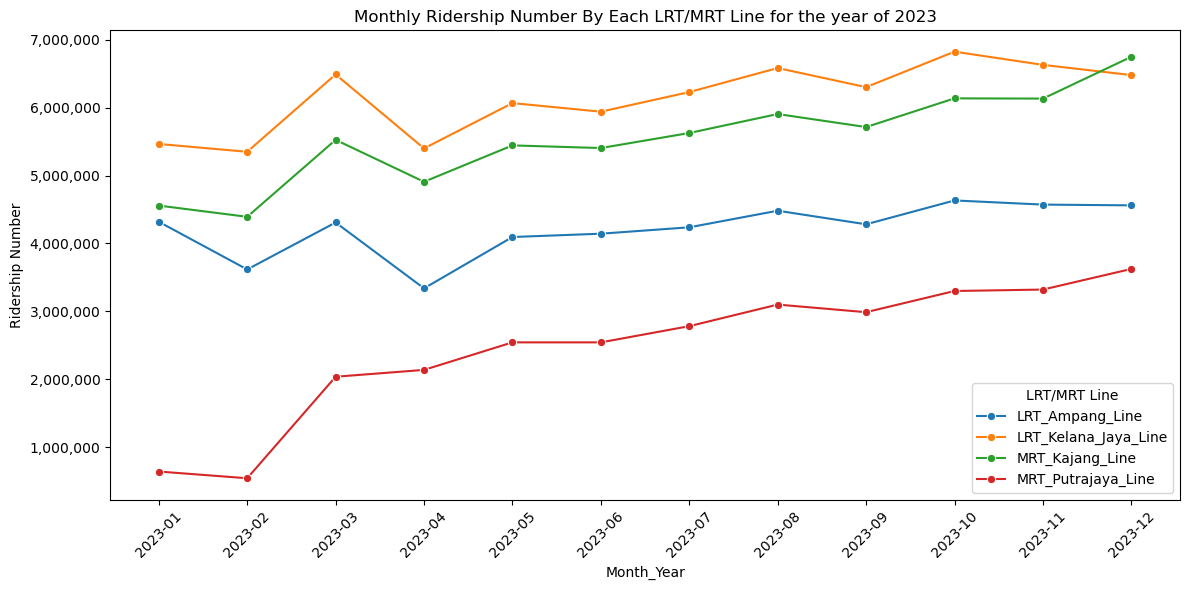

In [28]:
# Let's create a line graph to see the ridership numbers for each month for the year of 2023 for each of the LRT/MRT line 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_2023, 
    x='year_month', 
    y='Number of ridership',
    hue='LRT/MRT Line',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Monthly Ridership Number By Each LRT/MRT Line for the year of 2023') 
plt.xlabel('Month_Year') 
plt.ylabel('Ridership Number') 
plt.legend(title='LRT/MRT Line')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

### For the three lines (LRT Ampang Line, LRT Kelana Jaya Line and MRT Kajang Line), it has generally shown similar trends across all the lines with spikes in March 2023 and a slight dip in April 2023 before becoming stable from May 2023 onwards. The only major difference that happened after that is at the end of the year where LRT Kelana Jaya Line shows a dip in November and December 2023 whereas MRT Kajang Line remained relatively the same from October 2023 to November 2023 and increased again in December 2023 whereas LRT Ampang Line has remained largely stable over the same period.  

### MRT Kajang Line is relatively doing far higher numbers compared to pre-pandemic levels in this year which signifies far more demand. In contrast,  LRT Ampang Line and LRT Kelana Jaya line's numbers seems to be still a bit behind compared to pre-pandemic levels. 

### As for MRT Putrajaya Line, it shows a rapid increase in March 2023 which signifies the start of Phase 2 of this line and has gradually increased from month-to-month, indicating steady adoption following the network expansion. 

## Analysis of monthly volume for each line for the year of 2024

In [29]:
df_2024 = df_monthly_melted[df_monthly_melted['year'] == '2024'].reset_index(drop=True)
df_2024 = df_2024.drop(columns=['year_month_str','year'],axis=1) 
df_2024

,year_month,LRT/MRT Line,Number of ridership
0,2024-01,LRT_Ampang_Line,4505943
1,2024-02,LRT_Ampang_Line,4430513
2,2024-03,LRT_Ampang_Line,5196908
3,2024-04,LRT_Ampang_Line,4894934
4,2024-05,LRT_Ampang_Line,5607473
5,2024-06,LRT_Ampang_Line,5196642
6,2024-07,LRT_Ampang_Line,5626609
7,2024-08,LRT_Ampang_Line,5781159
8,2024-09,LRT_Ampang_Line,5365130
9,2024-10,LRT_Ampang_Line,5918334


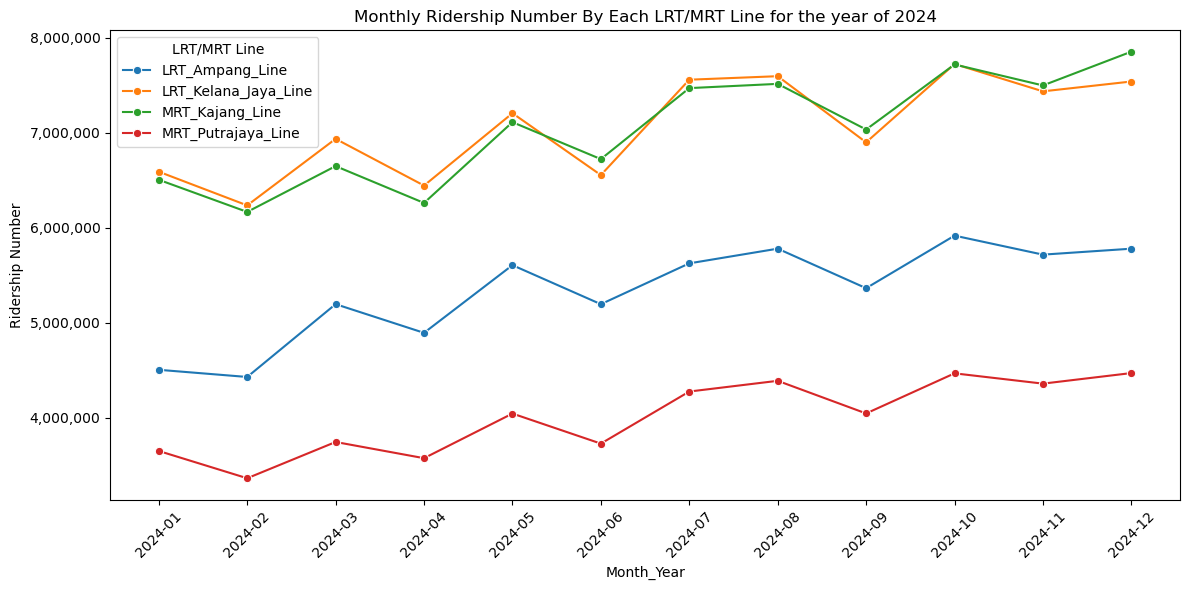

In [30]:
# Let's create a line graph to see the ridership numbers for each month for the year of 2024 for each of the LRT/MRT line 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_2024, 
    x='year_month', 
    y='Number of ridership',
    hue='LRT/MRT Line',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Monthly Ridership Number By Each LRT/MRT Line for the year of 2024') 
plt.xlabel('Month_Year') 
plt.ylabel('Ridership Number') 
plt.legend(title='LRT/MRT Line')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

### In the year of 2024, the two mature lines which have not reached pre-pandemic levels yet in the year of 2023 has finally reached to pre-pandemic levels. Although it has reached pre-pandemic levels, LRT Kelana Jaya is still yet to touch the peaks achieved by the line in the year of 2019. In contrast, LRT Ampang Line has touched some of the peaks recorded in the pre-pandemic levels. 

### As for MRT Kajang Line, it exhibits a notable structural shift. If we look at the pre-pandemic levels, the numbers were following nearly the same numbers recorded for LRT Ampang Line but in the year of 2024, the numbers are similar to the numbers recorded for LRT Kelana Jaya Line which used to be the highest recorded ridership numbers on month-on-month basis in the year of 2019. Some of the monthly ridership numbers recorded for MRT Kajang Line even exceeds the numbers recorded by LRT Kelana Jaya line. 

### Although MRT Kajang Line's 2023 and 2024 ridership numbers approach or exceed the pre-pandemic levels of LRT Kelana Jaya in 2019, the MRT line operates with larger train sets and comparable service frequencies which can indeed absorb higher passenger volumes. The higher demand for MRT Kajang Line compared to it's pre-pandemic levels could be because of higher development rate in terms of residential and commercial areas and it connects major hubs such as Bukit Bintang and TRX which could explain it's increased demand. 

### What we can observe in all these lines are intra-year seasonality remains evident, with recurring monthly spikes and dips except for certain months such as July 2024 to August 2024 where it remained relatively stable.

## Analysis of monthly volume for each line for the year of 2025

In [31]:
df_2025 = df_monthly_melted[df_monthly_melted['year'] == '2025'].reset_index(drop=True)
df_2025 = df_2025.drop(columns=['year_month_str','year'],axis=1) 
df_2025

,year_month,LRT/MRT Line,Number of ridership
0,2025-01,LRT_Ampang_Line,5583947
1,2025-02,LRT_Ampang_Line,5412652
2,2025-03,LRT_Ampang_Line,5755933
3,2025-04,LRT_Ampang_Line,5661642
4,2025-05,LRT_Ampang_Line,6216005
5,2025-06,LRT_Ampang_Line,5710467
6,2025-07,LRT_Ampang_Line,6350274
7,2025-08,LRT_Ampang_Line,6343844
8,2025-09,LRT_Ampang_Line,5664639
9,2025-10,LRT_Ampang_Line,6205243


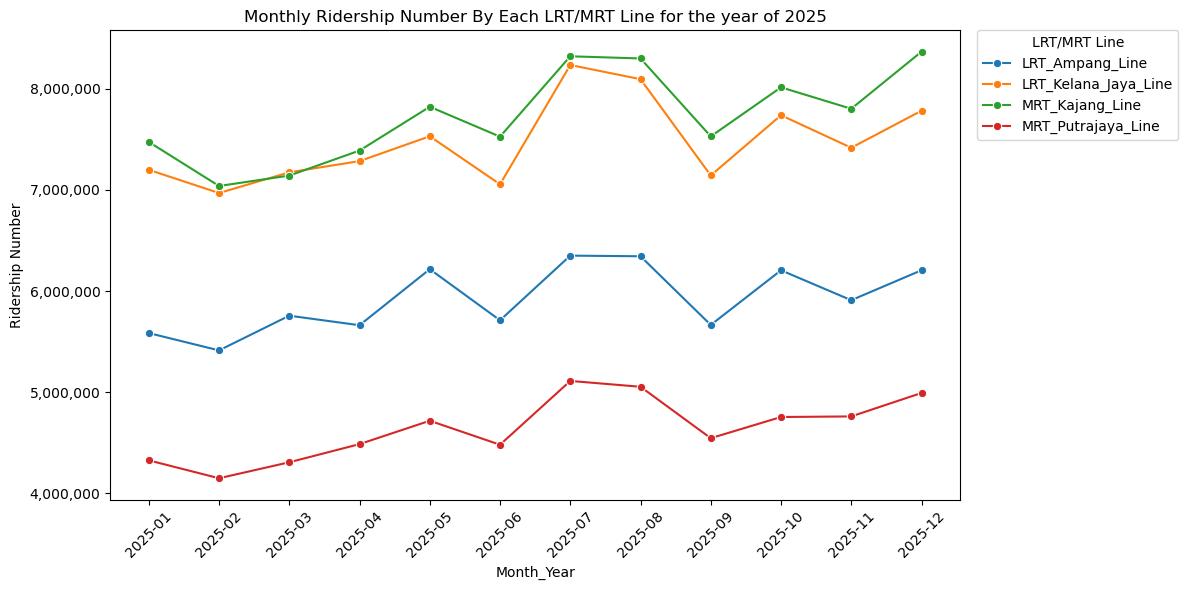

In [32]:
# Let's create a line graph to see the ridership numbers for each month for the year of 2025 for each of the LRT/MRT line 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_2025, 
    x='year_month', 
    y='Number of ridership',
    hue='LRT/MRT Line',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Monthly Ridership Number By Each LRT/MRT Line for the year of 2025') 
plt.xlabel('Month_Year') 
plt.ylabel('Ridership Number') 
plt.legend(
    title='LRT/MRT Line',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

### MRT Kajang Line has officially taken over the throne from LRT Kelana Jaya Line and emerged as the highest ridership line, consistently exceeding LRT Kelana Jaya line on a month-to-month basis starting from April 2025. As for the comparison with pre-pandemic levels, LRT Kelana Jaya has reached some of the peaks achieved in the pre-pandemic levels but it is still unable to achieve the highest peak reached in the year of 2019. 

### LRT Ampang Line's ridership numbers in 2025 is also much higher compared to the pre-pandemic levels, signifying increased demand currently compared to the pre-pandemic levels for this particular line. 

### MRT Putrajaya Line's ridership numbers continues to exhibit moderate growth throughout 2025, rising gradually across the year. The uptake for this MRT line is not as high as the ridership numbers recorded for MRT Kajang Line but the upward trend suggests ongoing network adoption rather than stagnation. 

## Analysis of monthly volume for each of the year for LRT Kelana Jaya Line

### We'll do an analysis of monthly volume for each of the year for LRT Kelana Jaya Line. We'll do this for each of the four lines separately. 

### We did a comparison analysis between the four lines for the monthly volume of each year to see the behaviour of the lines when pitted against each other for each of the year. In this manner, we will understand how each of the line is behaving and how they compare against each other in the pre-pandemic era and post-pandemic era. 

### In this analysis of monthly volume for each of the year which will be conducted for each of the line, we will understand the behaviour of each line separately throughout the years and this will also assist us in determining the start of the training period and testing period since we will further understand the timeline on each of the line on when it fully started recovering. Each of this line took a different timeline to recover completely and this analysis will assist us in that matter. 

In [33]:
df_lrt_kelanajaya = df_monthly_melted[df_monthly_melted['LRT/MRT Line'] == 'LRT_Kelana_Jaya_Line'].reset_index(drop=True)
df_lrt_kelanajaya['month'] = df_lrt_kelanajaya['year_month_str'].str[:-5] 
df_lrt_kelanajaya

,year_month,year_month_str,LRT/MRT Line,Number of ridership,year,month
0,2019-01,January 2019,LRT_Kelana_Jaya_Line,7900483,2019,January
1,2019-02,February 2019,LRT_Kelana_Jaya_Line,6523515,2019,February
2,2019-03,March 2019,LRT_Kelana_Jaya_Line,8127743,2019,March
3,2019-04,April 2019,LRT_Kelana_Jaya_Line,8189219,2019,April
4,2019-05,May 2019,LRT_Kelana_Jaya_Line,7746135,2019,May
...,...,...,...,...,...,...
79,2025-08,August 2025,LRT_Kelana_Jaya_Line,8095935,2025,August
80,2025-09,September 2025,LRT_Kelana_Jaya_Line,7143358,2025,September
81,2025-10,October 2025,LRT_Kelana_Jaya_Line,7739381,2025,October
82,2025-11,November 2025,LRT_Kelana_Jaya_Line,7417502,2025,November


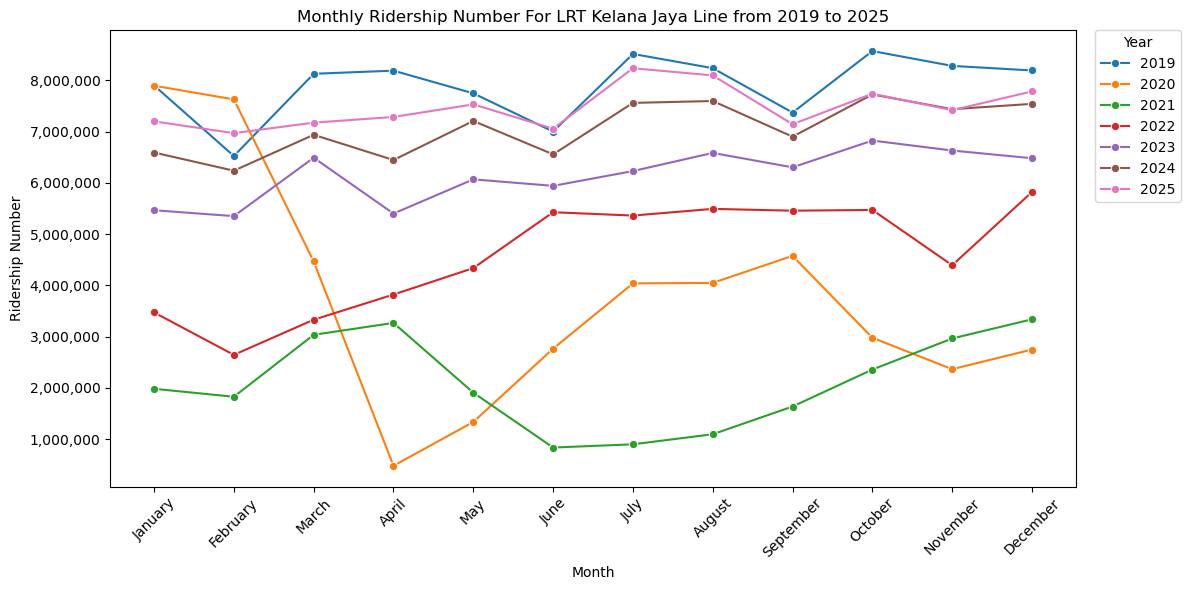

In [34]:
# Let's create a line graph to see the ridership numbers for each month for each of the year for LRT Kelana Jaya Line only 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_lrt_kelanajaya, 
    x='month', 
    y='Number of ridership',
    hue='year',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Monthly Ridership Number For LRT Kelana Jaya Line from 2019 to 2025') 
plt.xlabel('Month') 
plt.ylabel('Ridership Number') 
plt.legend(
    title='Year',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

### As mentioned in the earlier analysis, the ridership numbers for Kelana Jaya line in the year of 2025 is close to pre-pandemic levels but it has not exceeded the highest peak achieved in the pre-pandemic numbers. 

### We can see that the ridership numbers in the year of 2023 are more stable compared to the significant movement changes observed in the years following the pandemic. 

### For our training period, we can take the data starting from January 2023 to July 2025 and for the testing period, the data from August 2025 to December 2025 can be used and for forecasting, we will forecast the ridership numbers for Q1 of 2026 (January 2026 to March 2026). 

## Analysis of monthly volume for each of the year for MRT Kajang Line

In [35]:
df_mrt_kajang = df_monthly_melted[df_monthly_melted['LRT/MRT Line'] == 'MRT_Kajang_Line'].reset_index(drop=True)
df_mrt_kajang['month'] = df_mrt_kajang['year_month_str'].str[:-5] 
df_mrt_kajang

,year_month,year_month_str,LRT/MRT Line,Number of ridership,year,month
0,2019-01,January 2019,MRT_Kajang_Line,5206125,2019,January
1,2019-02,February 2019,MRT_Kajang_Line,4319140,2019,February
2,2019-03,March 2019,MRT_Kajang_Line,5393067,2019,March
3,2019-04,April 2019,MRT_Kajang_Line,5294479,2019,April
4,2019-05,May 2019,MRT_Kajang_Line,5155333,2019,May
...,...,...,...,...,...,...
79,2025-08,August 2025,MRT_Kajang_Line,8301044,2025,August
80,2025-09,September 2025,MRT_Kajang_Line,7530148,2025,September
81,2025-10,October 2025,MRT_Kajang_Line,8015428,2025,October
82,2025-11,November 2025,MRT_Kajang_Line,7803280,2025,November


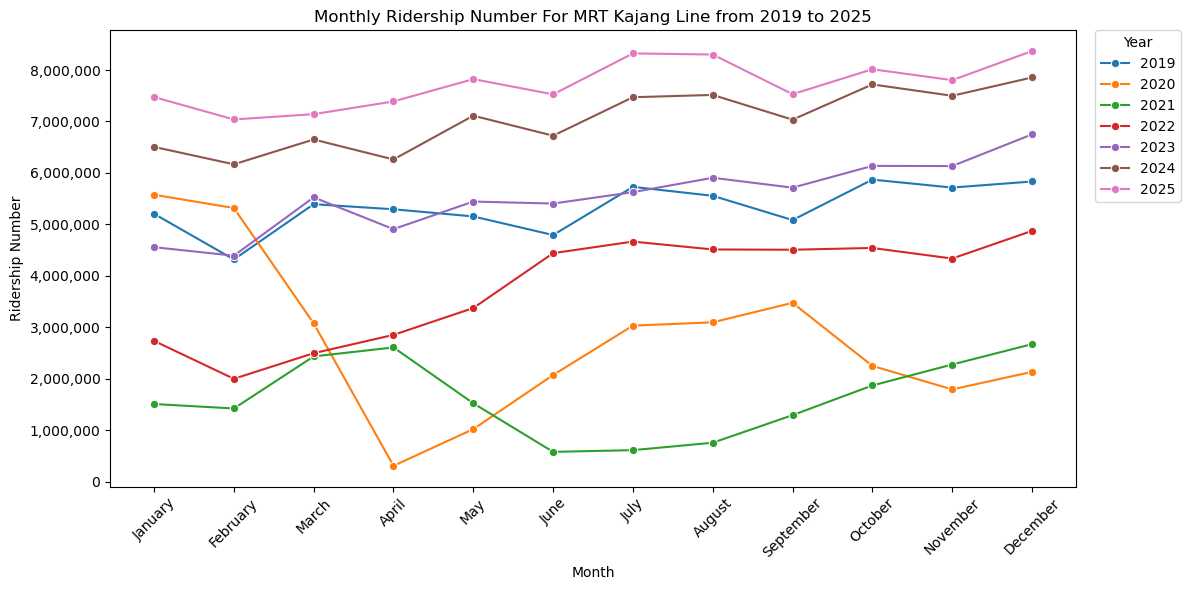

In [36]:
# Let's create a line graph to see the ridership numbers for each month for each of the year for MRT Kajang Line only 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_mrt_kajang, 
    x='month', 
    y='Number of ridership',
    hue='year',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Monthly Ridership Number For MRT Kajang Line from 2019 to 2025') 
plt.xlabel('Month') 
plt.ylabel('Ridership Number') 
plt.legend(
    title='Year',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

### As mentioned earlier, MRT Kajang Line has reached the pre-pandemic ridership number levels way before LRT Kelana Jaya Line and in contrast to LRT Kelana Jaya line, the ridership numbers have exceeded the pre-pandemic levels on a constant month-on-month basis starting from August 2023. 

### Based on the stabilisation pattern observed, we can take the training data starting from June 2022 to July 2025 and as for testing data, we can take it from August 2025 to December 2025. The forecasted values would be for Q1 of 2026 (January 2026 to March 2026). The reason the duration for training data's duration is different from LRT Kelana Jaya line is because LRT Kelana Jaya line experienced an anomalous dip in November 2022. Although the other months in 2nd half of 2022 experienced stable ridership numbers in the rest of that period, it might distort the forecasted values later on when we do future predictions for Q4 of 2026 later on. 

## Analysis of monthly volume for each of the year for LRT Ampang Line

In [37]:
df_lrt_ampang = df_monthly_melted[df_monthly_melted['LRT/MRT Line'] == 'LRT_Ampang_Line'].reset_index(drop=True)
df_lrt_ampang['month'] = df_lrt_ampang['year_month_str'].str[:-5] 
df_lrt_ampang

,year_month,year_month_str,LRT/MRT Line,Number of ridership,year,month
0,2019-01,January 2019,LRT_Ampang_Line,5363000,2019,January
1,2019-02,February 2019,LRT_Ampang_Line,4454115,2019,February
2,2019-03,March 2019,LRT_Ampang_Line,5617697,2019,March
3,2019-04,April 2019,LRT_Ampang_Line,5571821,2019,April
4,2019-05,May 2019,LRT_Ampang_Line,5458497,2019,May
...,...,...,...,...,...,...
79,2025-08,August 2025,LRT_Ampang_Line,6343844,2025,August
80,2025-09,September 2025,LRT_Ampang_Line,5664639,2025,September
81,2025-10,October 2025,LRT_Ampang_Line,6205243,2025,October
82,2025-11,November 2025,LRT_Ampang_Line,5909107,2025,November


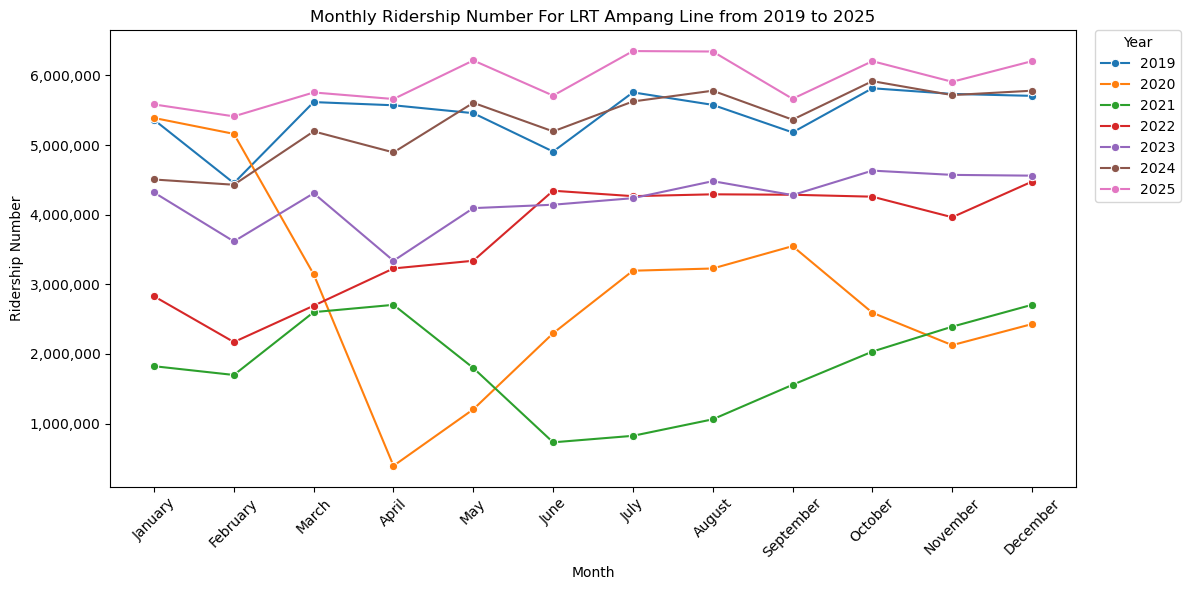

In [38]:
# Let's create a line graph to see the ridership numbers for each month for each of the year for LRT Ampang Line only 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_lrt_ampang, 
    x='month', 
    y='Number of ridership',
    hue='year',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Monthly Ridership Number For LRT Ampang Line from 2019 to 2025') 
plt.xlabel('Month') 
plt.ylabel('Ridership Number') 
plt.legend(
    title='Year',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

### For LRT Ampang Line, we can observe that the ridership levels have stabilised by the 2nd half of 2022 (the same period the stabilisation happened for MRT Kajang Line). The ridership numbers have constantly exceeded the pre-pandemic levels in the year of 2025 on the month-on-month basis for this line. 

### Therefore, for the training, testing and forecasted period, we can use similar durations employed for MRT Kajang Line which is June 2022 to July 2025 for training data, August 2025 to December 2025 for testing data and January 2026 to March 2026 for forecasted values. 

## Analysis of monthly volume for each of the year for MRT Putrajaya Line

In [39]:
df_monthly_melted.dtypes

year_month             object
year_month_str         object
LRT/MRT Line           object
Number of ridership     Int64
year                   object
dtype: object

In [40]:
# Since MRT Putrajaya Line only started it's operations in June 2022, we are only going to filter the data to only contain data from the year of 2022.
years_to_keep = ['2022','2023','2024','2025']
df_mrt_putrajaya = df_monthly_melted[(df_monthly_melted['LRT/MRT Line'] == 'MRT_Putrajaya_Line') & (df_monthly_melted['year'].isin(years_to_keep))].reset_index(drop=True)
df_mrt_putrajaya['month'] = df_mrt_putrajaya['year_month_str'].str[:-5] 
df_mrt_putrajaya

,year_month,year_month_str,LRT/MRT Line,Number of ridership,year,month
0,2022-01,January 2022,MRT_Putrajaya_Line,0,2022,January
1,2022-02,February 2022,MRT_Putrajaya_Line,0,2022,February
2,2022-03,March 2022,MRT_Putrajaya_Line,0,2022,March
3,2022-04,April 2022,MRT_Putrajaya_Line,0,2022,April
4,2022-05,May 2022,MRT_Putrajaya_Line,0,2022,May
5,2022-06,June 2022,MRT_Putrajaya_Line,369564,2022,June
6,2022-07,July 2022,MRT_Putrajaya_Line,688844,2022,July
7,2022-08,August 2022,MRT_Putrajaya_Line,579156,2022,August
8,2022-09,September 2022,MRT_Putrajaya_Line,605209,2022,September
9,2022-10,October 2022,MRT_Putrajaya_Line,629934,2022,October


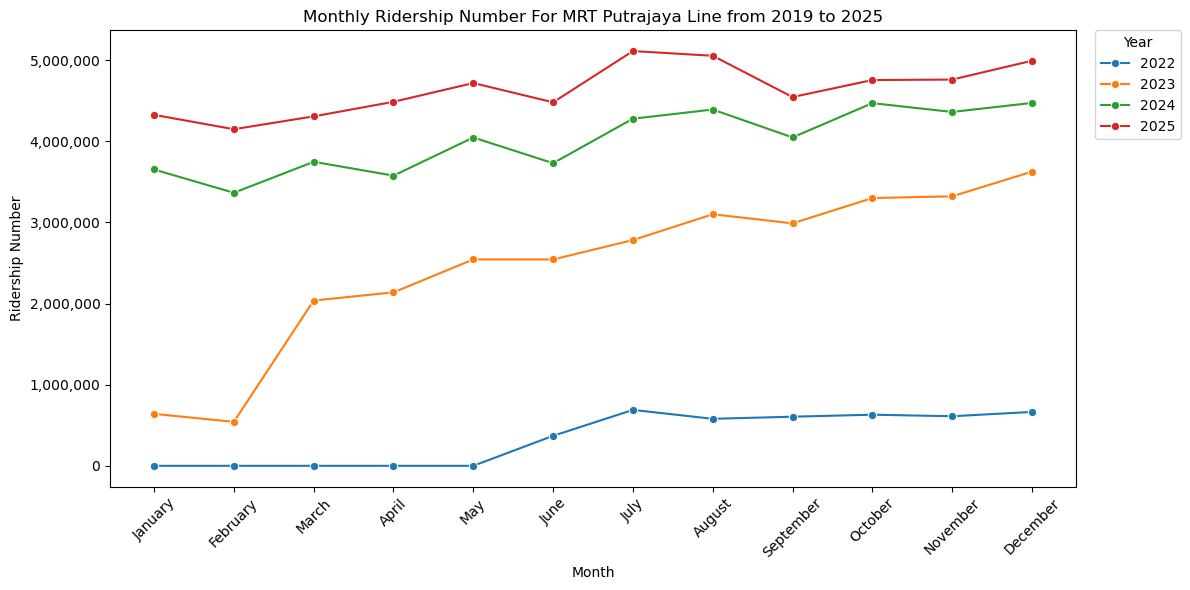

In [41]:
# Let's create a line graph to see the ridership numbers for each month for each of the year for MRT Putrajaya Line only 

plt.figure(figsize=(12, 6)) 

sns.lineplot(
    data = df_mrt_putrajaya, 
    x='month', 
    y='Number of ridership',
    hue='year',
    marker='o'
) 

# Format y-axis (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.title('Monthly Ridership Number For MRT Putrajaya Line from 2019 to 2025') 
plt.xlabel('Month') 
plt.ylabel('Ridership Number') 
plt.legend(
    title='Year',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

### The drastic change in ridership numbers happened in March 2023 when Phase 2 of the line is fully launched. It has stabilised around May 2023/June 2023 and exhibits a gradual upward trend with seasonal fluctuations. throughout the remaining of the months in the year. In the following years of 2024 and 2025, it has gradually increased from year-to-year, suggesting a positive uptake from the people in terms of ridership. 

### For this line, we have to start the training data much later than the other three lines. The training data starting period should be from May 2023 to July 2025 with the testing data taken to be from August 2025 to December 2025. The forecasted period would be for Q1 of 2026 (January 2026 to March 2026). 

## Training Data & Testing Data

In [42]:
# Create an integer column only containing the month and year of the data without the '-' symbol 

df_lrt_kelanajaya['year_month_rev'] = df_lrt_kelanajaya['year_month'].str[:4] + df_lrt_kelanajaya['year_month'].str[5:]
df_lrt_kelanajaya['year_month_rev'] = df_lrt_kelanajaya['year_month_rev'].astype(int)

df_mrt_kajang['year_month_rev'] = df_mrt_kajang['year_month'].str[:4] + df_mrt_kajang['year_month'].str[5:]
df_mrt_kajang['year_month_rev'] = df_mrt_kajang['year_month_rev'].astype(int)

df_lrt_ampang['year_month_rev'] = df_lrt_ampang['year_month'].str[:4] + df_lrt_ampang['year_month'].str[5:]
df_lrt_ampang['year_month_rev'] = df_lrt_ampang['year_month_rev'].astype(int)

df_mrt_putrajaya['year_month_rev'] = df_mrt_putrajaya['year_month'].str[:4] + df_mrt_putrajaya['year_month'].str[5:]
df_mrt_putrajaya['year_month_rev'] = df_mrt_putrajaya['year_month_rev'].astype(int)

In [43]:
# For training data of LRT Kelana Jaya line, it would be from January 2023 to July 2025 
# For testing data of LRT Kelana Jaya Line, it would be from August 2025 to December 2025 

# The training data for MRT Kajang Line would be from June 2022 to July 2025 
# The testing data for MRT Kajang line would be from August 2025 to December 2025 

# The training data for LRT Ampang line would be from June 2022 to July 2025 
# The testing data for LRT Ampang Line would be from August 2025 to December 2025 

# The training data for MRT Putrajaya line would be from May 2023 to August 2025 
# The testing data for MRT Putrajaya line would be from September 2025 to December 2025 

df_lrt_kj_train = df_lrt_kelanajaya[(df_lrt_kelanajaya['year_month_rev'] >= 202301) & (df_lrt_kelanajaya['year_month_rev'] <= 202507)].reset_index(drop=True) 
df_lrt_kj_test = df_lrt_kelanajaya[(df_lrt_kelanajaya['year_month_rev'] >= 202508) & (df_lrt_kelanajaya['year_month_rev'] <= 202512)].reset_index(drop=True)

df_mrt_kajang_train = df_mrt_kajang[(df_mrt_kajang['year_month_rev'] >= 202206) & (df_mrt_kajang['year_month_rev'] <= 202507)].reset_index(drop=True) 
df_mrt_kajang_test = df_mrt_kajang[(df_mrt_kajang['year_month_rev'] >= 202508) & (df_mrt_kajang['year_month_rev'] <= 202512)].reset_index(drop=True)

df_lrt_ampang_train = df_lrt_ampang[(df_lrt_ampang['year_month_rev'] >= 202206) & (df_lrt_ampang['year_month_rev'] <= 202507)].reset_index(drop=True) 
df_lrt_ampang_test = df_lrt_ampang[(df_lrt_ampang['year_month_rev'] >= 202508) & (df_lrt_ampang['year_month_rev'] <= 202512)].reset_index(drop=True)

df_mrt_putrajaya_train = df_mrt_putrajaya[(df_mrt_putrajaya['year_month_rev'] >= 202305) & (df_mrt_putrajaya['year_month_rev'] <= 202507)].reset_index(drop=True) 
df_mrt_putrajaya_test = df_mrt_putrajaya[(df_mrt_putrajaya['year_month_rev'] >= 202508) & (df_mrt_putrajaya['year_month_rev'] <= 202512)].reset_index(drop=True)

In [44]:
# Consolidate all the training data into a dataframe and feed it into the model 
df_training_data_cons = pd.concat([df_lrt_kj_train,df_mrt_kajang_train,df_lrt_ampang_train,df_mrt_putrajaya_train]) 
df_training_data = df_training_data_cons.drop(columns=['year_month_str','year','month','year_month_rev'],axis=0).reset_index(drop=True)
df_training_data

,year_month,LRT/MRT Line,Number of ridership
0,2023-01,LRT_Kelana_Jaya_Line,5465184
1,2023-02,LRT_Kelana_Jaya_Line,5350230
2,2023-03,LRT_Kelana_Jaya_Line,6489551
3,2023-04,LRT_Kelana_Jaya_Line,5399898
4,2023-05,LRT_Kelana_Jaya_Line,6067411
...,...,...,...
129,2025-03,MRT_Putrajaya_Line,4305723
130,2025-04,MRT_Putrajaya_Line,4485310
131,2025-05,MRT_Putrajaya_Line,4716456
132,2025-06,MRT_Putrajaya_Line,4479168


In [45]:
# Consolidate all the test data into a single dataframe 
df_test_data_cons = pd.concat([df_lrt_kj_test,df_mrt_kajang_test,df_lrt_ampang_test,df_mrt_putrajaya_test]) 
df_test_data = df_test_data_cons.drop(columns=['year_month_str','year','month','year_month_rev'],axis=0).reset_index(drop=True)
df_test_data

,year_month,LRT/MRT Line,Number of ridership
0,2025-08,LRT_Kelana_Jaya_Line,8095935
1,2025-09,LRT_Kelana_Jaya_Line,7143358
2,2025-10,LRT_Kelana_Jaya_Line,7739381
3,2025-11,LRT_Kelana_Jaya_Line,7417502
4,2025-12,LRT_Kelana_Jaya_Line,7784113
5,2025-08,MRT_Kajang_Line,8301044
6,2025-09,MRT_Kajang_Line,7530148
7,2025-10,MRT_Kajang_Line,8015428
8,2025-11,MRT_Kajang_Line,7803280
9,2025-12,MRT_Kajang_Line,8368266


In [46]:
for line in df_training_data['LRT/MRT Line'].unique():
    print(line)
    print("Train:", df_training_data[df_training_data['LRT/MRT Line']==line]['year_month'].min(),
          "→", df_training_data[df_training_data['LRT/MRT Line']==line]['year_month'].max())
    print("Test :", df_test_data[df_test_data['LRT/MRT Line']==line]['year_month'].min(),
          "→", df_test_data[df_test_data['LRT/MRT Line']==line]['year_month'].max())
    print("-"*50)

LRT_Kelana_Jaya_Line
Train: 2023-01 → 2025-07
Test : 2025-08 → 2025-12
--------------------------------------------------
MRT_Kajang_Line
Train: 2022-06 → 2025-07
Test : 2025-08 → 2025-12
--------------------------------------------------
LRT_Ampang_Line
Train: 2022-06 → 2025-07
Test : 2025-08 → 2025-12
--------------------------------------------------
MRT_Putrajaya_Line
Train: 2023-05 → 2025-07
Test : 2025-08 → 2025-12
--------------------------------------------------


In [47]:
df_training_data['year_month'] = pd.to_datetime(df_training_data['year_month'])
df_test_data['year_month'] = pd.to_datetime(df_test_data['year_month'])

In [48]:
for line in df_training_data['LRT/MRT Line'].unique():
    n = len(df_training_data[df_training_data['LRT/MRT Line']==line])
    print(line, n)

LRT_Kelana_Jaya_Line 31
MRT_Kajang_Line 38
LRT_Ampang_Line 38
MRT_Putrajaya_Line 27


In [49]:
df_training_data_ver2 = df_training_data[(df_training_data['LRT/MRT Line'] != 'MRT_Putrajaya_Line') & (df_training_data['LRT/MRT Line'] != 'LRT_Kelana_Jaya_Line')] 

In [50]:
df_training_data_ver2['LRT/MRT Line'].unique()

array(['MRT_Kajang_Line', 'LRT_Ampang_Line'], dtype=object)

In [51]:
# Run the Prophet model to do the time-series forecasting for Q1 of 2026 for all four lines 

results = {}
metrics = []
test_results = []
q1_results = []

for line in df_training_data['LRT/MRT Line'].unique():

    train = (
        df_training_data[df_training_data['LRT/MRT Line'] == line]
        .rename(columns={'year_month':'ds', 'Number of ridership':'y'})
        .sort_values('ds')
    )

    test = (
        df_test_data[df_test_data['LRT/MRT Line'] == line]
        .rename(columns={'year_month':'ds', 'Number of ridership':'y'})
        .sort_values('ds')
    )

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.3
    )

    m.fit(train)

    # Test forecast
    future_test = test[['ds']]
    test_pred = m.predict(future_test)['yhat'].values

    test_compare = test[['ds', 'y']].copy()
    test_compare['Predicted'] = test_pred
    test_compare['Line'] = line
    test_results.append(test_compare)

    mae = mean_absolute_error(test['y'], test_pred)
    mape = np.mean(np.abs((test['y'] - test_pred) / test['y'])) * 100

    test_compare = test[['ds', 'y']].copy()
    test_compare['Predicted'] = test_pred
    test_compare['Line'] = line

    test_compare['Abs_Error'] = (test_compare['y'] - test_compare['Predicted']).abs()
    test_compare['APE'] = test_compare['Abs_Error'] / test_compare['y'] * 100

    mae = test_compare['Abs_Error'].mean()
    mape = test_compare['APE'].mean()

    test_compare['MAE'] = round(mae, 2)
    test_compare['MAPE'] = round(mape, 2)

    test_results.append(test_compare)

    # Q1 2026 forecast
    future_q1 = pd.DataFrame({
        'ds': pd.date_range('2026-01-01', '2026-03-01', freq='MS')
    })

    forecast = m.predict(future_q1)

    q1_table = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    q1_table['Line'] = line

    q1_results.append(q1_table)

    results[line] = {
        'model': m,
        'test_pred': test_pred,
        'forecast': forecast
    }

    metrics.append([line, round(mae,2), round(mape,2)])

16:44:11 - cmdstanpy - INFO - Chain [1] start processing
16:44:12 - cmdstanpy - INFO - Chain [1] done processing
16:44:12 - cmdstanpy - INFO - Chain [1] start processing
16:44:14 - cmdstanpy - INFO - Chain [1] done processing
16:44:14 - cmdstanpy - INFO - Chain [1] start processing
16:44:15 - cmdstanpy - INFO - Chain [1] done processing
16:44:15 - cmdstanpy - INFO - Chain [1] start processing
16:45:00 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
df_actual_predicted = pd.concat(test_results)

df_actual_predicted['Month'] = df_actual_predicted['ds'].dt.strftime('%b %Y')
df_actual_predicted = df_actual_predicted[(df_actual_predicted['Abs_Error'].notnull()) & (df_actual_predicted['APE'].notnull()) & (df_actual_predicted['MAE'].notnull()) & (df_actual_predicted['MAPE'].notnull())]
df_actual_predicted[['y', 'Predicted', 'Abs_Error']] = df_actual_predicted[['y', 'Predicted', 'Abs_Error']].round(0).astype(int)
df_actual_predicted['APE'] = df_actual_predicted['APE'].round(2)
df_actual_predicted.rename(columns={'y':'Actual'}, inplace=True)

df_actual_predicted = df_actual_predicted[['Line', 'Month', 'Actual', 'Predicted', 'Abs_Error', 'APE', 'MAE', 'MAPE']]
df_actual_predicted

,Line,Month,Actual,Predicted,Abs_Error,APE,MAE,MAPE
0,LRT_Kelana_Jaya_Line,Aug 2025,8095935,8149901,53966,0.67,403442.51,5.37
1,LRT_Kelana_Jaya_Line,Sep 2025,7143358,7609270,465912,6.52,403442.51,5.37
2,LRT_Kelana_Jaya_Line,Oct 2025,7739381,8323163,583782,7.54,403442.51,5.37
3,LRT_Kelana_Jaya_Line,Nov 2025,7417502,8054245,636743,8.58,403442.51,5.37
4,LRT_Kelana_Jaya_Line,Dec 2025,7784113,8060922,276809,3.56,403442.51,5.37
5,MRT_Kajang_Line,Aug 2025,8301044,8258531,42513,0.51,331724.55,4.21
6,MRT_Kajang_Line,Sep 2025,7530148,7980941,450793,5.99,331724.55,4.21
7,MRT_Kajang_Line,Oct 2025,8015428,8442740,427312,5.33,331724.55,4.21
8,MRT_Kajang_Line,Nov 2025,7803280,8258435,455155,5.83,331724.55,4.21
9,MRT_Kajang_Line,Dec 2025,8368266,8651116,282850,3.38,331724.55,4.21


### For the LRT Kelana Jaya Line, predicted ridership is consistently higher than actual values across all five test months, indicating a systematic overestimation bias. The highest deviation occurs in November 2025 (APE = 8.58%), while the overall MAPE for the period is 5.37%, which remains within an acceptable range for demand forecasting.

### For the MRT Kajang Line, predicted values are slightly lower than actual only in August 2025, while the remaining months show moderate overestimation. The largest deviation occurs in September 2025 (APE = 5.99%). The overall MAPE of 4.21% indicates that the model has successfully learned the seasonal structure of this line.

### The LRT Ampang Line shows a similar pattern, with under-prediction in August 2025 followed by over-prediction in subsequent months. The highest APE is observed in September 2025 (7.21%). However, the overall MAPE of 4.04% is the lowest among all four lines, making this the best-performing model.

### The MRT Putrajaya Line exhibits the largest deviations, with predicted values exceeding actual ridership in all five months. October 2025 records the highest APE at 15.68%, and the line-level MAPE is 11.21%, making it the weakest-performing model. This is expected, as MRT Putrajaya has the shortest stable training history following its Phase 2 opening in March 2023, and remains in a post-expansion growth regime.

### A clear pattern emerges: lines with longer stable training histories (MRT Kajang and LRT Ampang, trained from June 2022) achieve lower forecast error compared to lines with shorter post-stabilisation histories (LRT Kelana Jaya and MRT Putrajaya). This confirms that exposure to multiple annual cycles significantly improves seasonal learning.

### To further improve accuracy, approximately 6 additional months of stable data are likely required for LRT Kelana Jaya to reduce MAPE below 5%, while at least 12 additional months may be required for MRT Putrajaya.

### In transport demand forecasting, MAPE values below 5% are considered strong, while 5–10% is acceptable for planning use. Future enhancements may include incorporating exogenous variables such as school holidays, public holidays, working-day counts, and service disruptions, as well as benchmarking against SARIMA-based models for robustness.

In [53]:
df_forecast_q1 = pd.concat(q1_results)

df_forecast_q1['Month'] = df_forecast_q1['ds'].dt.strftime('%b %Y')
df_forecast_q1 = df_forecast_q1[['Line', 'Month', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index(drop=True)

df_forecast_q1[['yhat', 'yhat_lower', 'yhat_upper']] = df_forecast_q1[['yhat', 'yhat_lower', 'yhat_upper']].round(0).astype(int)
df_forecast_q1

,Line,Month,yhat,yhat_lower,yhat_upper
0,LRT_Kelana_Jaya_Line,Jan 2026,7821072,7699478,7946238
1,LRT_Kelana_Jaya_Line,Feb 2026,7564216,7431605,7683645
2,LRT_Kelana_Jaya_Line,Mar 2026,8270751,8127436,8402629
3,MRT_Kajang_Line,Jan 2026,8220635,8116406,8328834
4,MRT_Kajang_Line,Feb 2026,7788140,7651245,7932416
5,MRT_Kajang_Line,Mar 2026,8335496,8142703,8544881
6,LRT_Ampang_Line,Jan 2026,6254326,6113754,6390907
7,LRT_Ampang_Line,Feb 2026,5944164,5802480,6080463
8,LRT_Ampang_Line,Mar 2026,6602103,6458890,6754705
9,MRT_Putrajaya_Line,Jan 2026,5332045,5296514,5367964


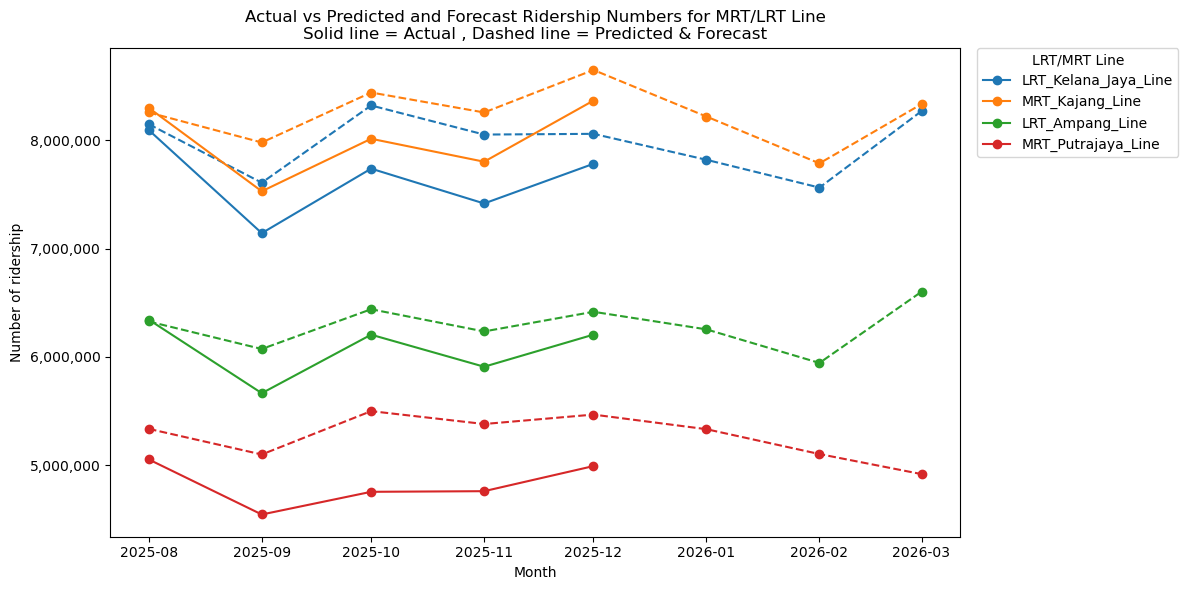

In [54]:
# Build the line graph for the actual and predicted values from August 2025 to December 2025 and later on for forecasted values for January 2026 
# to March 2026. 

# The data for actual ridership numbers would be represented by the solid line while the data for ridership numbers for predicted ridership numbers 
# and forecasted ridership numbers would be represented by the dashed line. 

plt.figure(figsize=(12,6))

df_actual_predicted["Month"] = pd.to_datetime(df_actual_predicted["Month"], format="%b %Y")
df_forecast_q1["Month"] = pd.to_datetime(df_forecast_q1["Month"], format="%b %Y")

for line in df_actual_predicted["Line"].unique():
    actual_pred = df_actual_predicted[df_actual_predicted["Line"] == line].sort_values("Month")
    forecast = df_forecast_q1[df_forecast_q1["Line"] == line].sort_values("Month")

    # The actual ridership numbers would be in solid line. 
    
    actual_line, = plt.plot(
        actual_pred["Month"],
        actual_pred["Actual"],
        marker="o",
        label=line
    )

    color = actual_line.get_color()  


    # Model output = Predicted + Forecast (dashed, one line)
    model_x = list(actual_pred["Month"]) + list(forecast["Month"])
    model_y = list(actual_pred["Predicted"]) + list(forecast["yhat"])

    plt.plot(
        model_x,
        model_y,
        linestyle="--",
        marker="o",
        color=color,
    )

plt.xlabel("Month")
plt.ylabel("Number of ridership")
plt.ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.title("Actual vs Predicted and Forecast Ridership Numbers for MRT/LRT Line\n"
          "Solid line = Actual , Dashed line = Predicted & Forecast")
plt.legend(
    title='LRT/MRT Line',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)
plt.tight_layout()
plt.show()

# --- END ---